## Import required libraries

In [1]:
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
# open source implementation of LBP
from skimage.feature import local_binary_pattern
# data preprocessing and metrics module in scikit-learn
from sklearn import preprocessing, metrics
# SVM implementation in scikit-learn
from sklearn.svm import LinearSVC

Download images

In [3]:
def doonload_data(file, url):

    # Check if the file already exists
    if not os.path.exists(file):
        print('Downloading ' + file + '...')
        
        # Download the file from the specified URL
        urllib.request.urlretrieve(url, file)

        # Extract the contents of the downloaded file into 'data' directory
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall('data')
        
        # Remove the downloaded zip file
        os.remove(file)

        print('Done!')
    else:
        print(file + ' already exists.')

In [4]:
file = 's3_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file

# Download the data file
doonload_data(file, url)


Done!


## local binary pattern

In [5]:
def compute_lbp(arr):

    """
    Find the local binary pattern representation of the given image.
    Peform Vectorization/Normalization of the image to get feature vector.
    """

    # parameters for LBP
    radius = 1
    n_points = 8 * radius
    n_bins = n_points + 2 # number of neighbors n_points + 2 (for center pixel + 2)
    lbp = local_binary_pattern(arr, n_points, radius, method='uniform') # LBP representation
    lbp = lbp.ravel() # vectorization: convert 2D array to 1D array
    
    # normalization 
    feature = np.zeros(n_bins) # initialize feature vector
    for i in lbp:
        feature[int(i)] += 1 # count the number of occurences of each value
    feature /= np.linalg.norm(feature) # normalize the feature vector
    return feature

## Load data

In [13]:
def load_data(tag='data/train'):

    """
    Load the data from the given directory.
    """

    
    tag_dir = Path.cwd() / tag # path to the directory
    vec = [] # list of feature vectors
    cat = [] # list of categories
    for cat_dir in tag_dir.iterdir(): # iterate over the subdirectories
        cat_label = cat_dir.stem # get the name of the subdirectory
        for img_path in cat_dir.glob('*.png'): # iterate over the images in the subdirectory
            img = Image.open(img_path.as_posix()) # open the image
            if img.mode != 'L': # convert the image to grayscale if it is not already
                img = ImageOps.grayscale(img) # convert the image to grayscale
                img.save(img_path.as_posix())  # save the image, img_path.as_posix() returns the path as a string
            arr = np.array(img) # convert the image to numpy array
            feature = compute_lbp(arr) # compute the feature vector
            vec.append(feature) # append the feature vector to the list of feature vectors
            cat.append(cat_label) # append the category to the list of categories
    return vec, cat

# train photos
vec_train, cat_train = load_data('data/train')
# test photos
vec_test, cat_test   = load_data('data/test')

In [36]:
# get the unique categories
labels = list(np.unique(np.array(cat_train)))
labels

['Sand', 'Seed', 'Stone']

In [37]:
# label encoder
le = preprocessing.LabelEncoder()
label_train = le.fit_transform(cat_train)
label_test = le.transform(cat_test)

In [38]:
# SVM classifier
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(vec_train, label_train)

LinearSVC(random_state=0, tol=1e-05)

Accuracy: 100.00%


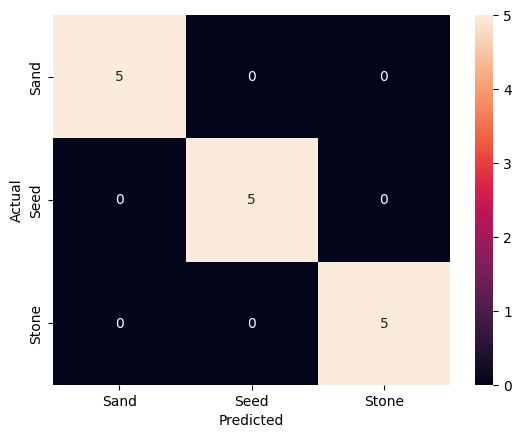

In [39]:
# test set evaluation
prediction = clf.predict(vec_test)
# visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))